## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# https://medium.com/@alexppppp/how-to-train-a-custom-keypoint-detection-model-with-pytorch-d9af90e111da

import cv2, numpy as np, matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models.detection.rpn import AnchorGenerator

# https://github.com/pytorch/vision/tree/main/references/detection
from utils import collate_fn
from engine import train_one_epoch, evaluate

## Useful tools

In [6]:
from random_map_generation import random_map
from track_tools import consistent_scale_plot


MAP_SIZE = 2000


def get_margins(image, IMG_WIDTH, IMG_HEIGHT):
    """Find the margins of the image. 
    Used to translate pixel coordinates to meter coordinates """
    image = (image.permute(1,2,0).numpy() * 255).astype(np.uint8)
    row = image[400]

    first_black = np.where(row < 255)[0][0]
    left_margin = (np.where(row[first_black:] == 255) + first_black)[0][0]

    last_black = np.where(row < 255)[0][-1]
    right_margin = (IMG_WIDTH - np.where(row[:last_black] == 255)[0])[-1]

    column = np.array([image[i][450] for i in range(image.shape[0])])
    first_black = np.where(column < 255)[0][0]
    top_margin = (np.where(column[first_black:] == 255) + first_black)[0][0]

    last_black = np.where(column < 255)[0][-1]
    bottom_margin = (IMG_HEIGHT - np.where(column[:last_black] == 255)[0])[-1]

    return {"LEFT": left_margin, "RIGHT": right_margin, "TOP": top_margin, "BOTTOM": bottom_margin}


class ClassDataset(Dataset):
    def __init__(self, length=64):                
        self.length = length
        points = random_map()["points"]
        
        img = self.image_tensor_from_points(points)
        self.MARGINS = get_margins(img, self.IMG_HEIGHT, self.IMG_WIDTH)


    def image_tensor_from_points(self, points):
        """Generate a tensor from a set of GPS points.
        Generates image, then converts image into a tensor for input into the model"""
        fig = consistent_scale_plot(points, MAP_SIZE=MAP_SIZE)
        fig.canvas.draw()
        np_fig = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)

        self.IMG_HEIGHT = int(np.sqrt(len(np_fig) / 3))
        self.IMG_WIDTH = self.IMG_HEIGHT

        img = torch.Tensor([np_fig[0::3], np_fig[1::3], np_fig[2::3]])   # needs to be in C, H, W format. Image is 1000x1000. Colour RGB
        img = torch.reshape(img, (3, self.IMG_HEIGHT, self.IMG_WIDTH)) / 255

        plt.clf()
        plt.close()

        return img


    def x_point_to_image_coords(self, x, points_mean):
        """Convert x coordinate from GPS points into pixel coordinates in the image"""
        CANVAS_WIDTH  = self.IMG_WIDTH  - self.MARGINS["LEFT"] - self.MARGINS["RIGHT"]
        return self.MARGINS["LEFT"] + CANVAS_WIDTH // 2 + (x - points_mean) * (CANVAS_WIDTH   // 2) / MAP_SIZE


    def y_point_to_image_coords(self, y, points_mean):
        """Convert y coordinate from GPS points into pixel coordinates in the image"""
        CANVAS_HEIGHT = self.IMG_HEIGHT - self.MARGINS["TOP"]  - self.MARGINS["BOTTOM"]
        return self.MARGINS["TOP"] + CANVAS_HEIGHT // 2 + (-y + points_mean) * (CANVAS_HEIGHT // 2) / MAP_SIZE


    def __getitem__(self, idx):
        """Generate a random image with keypoints and bounding box"""
        map = random_map()

        # Convert keypoints into a tensor
        keypoints = map["keypoints"]
        keypoints = torch.as_tensor([[[self.x_point_to_image_coords(x, map["points"].x.mean()), 
                                       self.y_point_to_image_coords(y, map["points"].y.mean()), 1] 
                                      for x, y in zip(keypoints.x.values, keypoints.y.values)]], 
                                    dtype=torch.float32)

        # Generate tensor of the GPS points
        img = self.image_tensor_from_points(map["points"])
        
        # Convert bounding box points into a tensor
        bboxes = map["bbox"]
        bboxes = torch.as_tensor([[self.x_point_to_image_coords(bboxes.x.values[0], map["points"].x.mean()), 
                                   self.y_point_to_image_coords(bboxes.y.values[0], map["points"].y.mean()), 
                                   self.x_point_to_image_coords(bboxes.x.values[1], map["points"].x.mean()), 
                                   self.y_point_to_image_coords(bboxes.y.values[1], map["points"].y.mean())]], 
                                dtype=torch.float32)        
        
        # Convert everything into a torch tensor        
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)       
        target = {}
        target["boxes"] = bboxes
        target["labels"] = torch.as_tensor([1 for _ in bboxes], dtype=torch.int64) # all objects are track
        target["image_id"] = torch.tensor([idx])
        target["area"] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        target["iscrowd"] = torch.zeros(len(bboxes), dtype=torch.int64)
        target["keypoints"] = keypoints

        return img, target
    
    def __len__(self):
        # This affects how many images are used in training and testing
        return self.length
    

dataset = ClassDataset()
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

iterator = iter(data_loader)
batch = next(iterator)

print("Original targets:\n", batch[1], "\n\n")

/tmp/ipykernel_5363/1434397300.py:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  img = torch.Tensor([np_fig[0::3], np_fig[1::3], np_fig[2::3]])   # needs to be in C, H, W format. Image is 1000x1000. Colour RGB


Original targets:
 ({'boxes': tensor([[501.3181, 486.6041, 534.2592, 508.0842]]), 'labels': tensor([1]), 'image_id': tensor([29]), 'area': tensor([707.5806]), 'iscrowd': tensor([0]), 'keypoints': tensor([[[517.7886, 497.3441,   1.0000],
         [509.9576, 495.1988,   1.0000]]])},) 




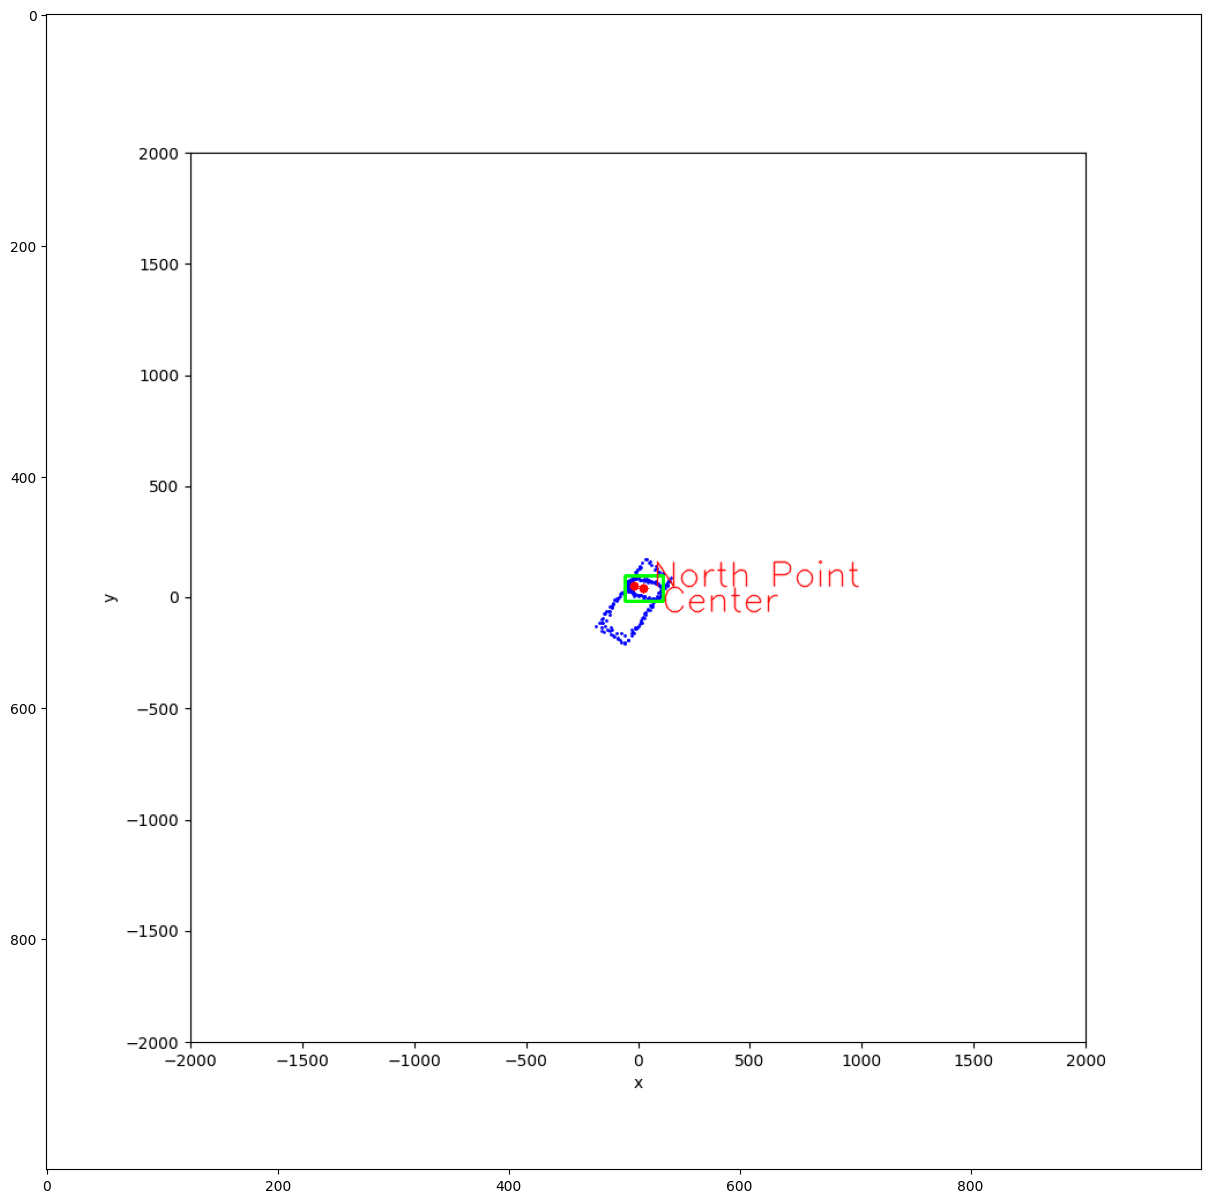

In [8]:
keypoints_classes_ids2names = {0: 'Center', 1: 'North Point'}


def visualize(image, bboxes, keypoints):
    """Visualise map images with keypoints and bounding boxes"""
    fontsize = 15
    
    for bbox in bboxes:
        start_point = (bbox[0], bbox[1])
        end_point = (bbox[2], bbox[3])
        image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 2)
    
    for kps in keypoints:
        for idx, kp in enumerate(kps):
            if keypoints_classes_ids2names[idx] == "Center":
                image = cv2.circle(image.copy(), tuple(kp), 4, (255,0,0), -1)
                kp[1] += 20
                image = cv2.putText(image.copy(), " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 1, cv2.LINE_AA)
            else:
                image = cv2.circle(image.copy(), tuple(kp), 4, (255,0,0), -1)
                image = cv2.putText(image.copy(), " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 1, cv2.LINE_AA)
    
    plt.figure(figsize=(15, 15))
    plt.imshow(image)
        

image = (batch[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints = []
for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints.append([kp[:2] for kp in kps])

visualize(image, bboxes, keypoints) #, image_original, bboxes_original, keypoints_original)

from torchvision.utils import save_image
save_image(batch[0][0], 'random_image.png')

## Load, train and evaluate the model

In [6]:
def get_model(num_keypoints, weights_path=None):
    # Download model 
    anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0))
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False,
                                                                   pretrained_backbone=True,
                                                                   num_keypoints=num_keypoints,
                                                                   num_classes = 2, # Background is the first class, object is the second class
                                                                   rpn_anchor_generator=anchor_generator)

    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)        
        
    return model

In [21]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Train on 512 images per epoch
dataset_train = ClassDataset(length=512)

# Test with 256 images
dataset_test = ClassDataset(length=256)

data_loader_train = DataLoader(dataset_train, batch_size=3, shuffle=True, collate_fn=collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

model = get_model(num_keypoints = 2)

# Name of pretrained keypoint model - remove if none
MODEL_PATH = 'keypointsrcnn_weights.pth'
model.load_state_dict(torch.load(MODEL_PATH))
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)
num_epochs = 5

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=100)

    # if epoch % 5 == 0:
    #     torch.save(model.state_dict(), MODEL_PATH[:-4] + "-" + str(epoch) + ".pth")
    lr_scheduler.step()
    evaluate(model, data_loader_test, device)
    
# Save model weights after training
# torch.save(model.state_dict(), MODEL_PATH)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to 

Epoch: [0]  [  0/171]  eta: 0:01:51  lr: 0.000007  loss: 2.4077 (2.4077)  loss_classifier: 0.0210 (0.0210)  loss_box_reg: 0.0603 (0.0603)  loss_keypoint: 2.3142 (2.3142)  loss_objectness: 0.0108 (0.0108)  loss_rpn_box_reg: 0.0015 (0.0015)  time: 0.6505  data: 0.3480  max mem: 3701


KeyboardInterrupt: 

In [8]:
from engine import evaluate
# model.load_state_dict(torch.load(MODEL_PATH))

# evaluate returns the image with the highest error for debugging purposes
worst_image, worst_pred = evaluate(model, data_loader_test, device)

Test:  [  0/256]  eta: 0:00:52  model_time: 0.0618 (0.0618)  evaluator_time: 0.0000 (0.0000)  time: 0.2042  data: 0.1413  max mem: 2795
Test:  [100/256]  eta: 0:00:29  model_time: 0.0512 (0.0541)  evaluator_time: 0.0000 (0.0000)  time: 0.1794  data: 0.1261  max mem: 2795
Test:  [200/256]  eta: 0:00:10  model_time: 0.0532 (0.0547)  evaluator_time: 0.0000 (0.0000)  time: 0.1859  data: 0.1305  max mem: 2795
Test:  [255/256]  eta: 0:00:00  model_time: 0.0536 (0.0542)  evaluator_time: 0.0000 (0.0000)  time: 0.1886  data: 0.1339  max mem: 2795
Test: Total time: 0:00:48 (0.1881 s / it)
RMSE: tensor(1.8640)
Averaged stats: model_time: 0.0536 (0.0542)  evaluator_time: 0.0000 (0.0000)


## Find bad examples

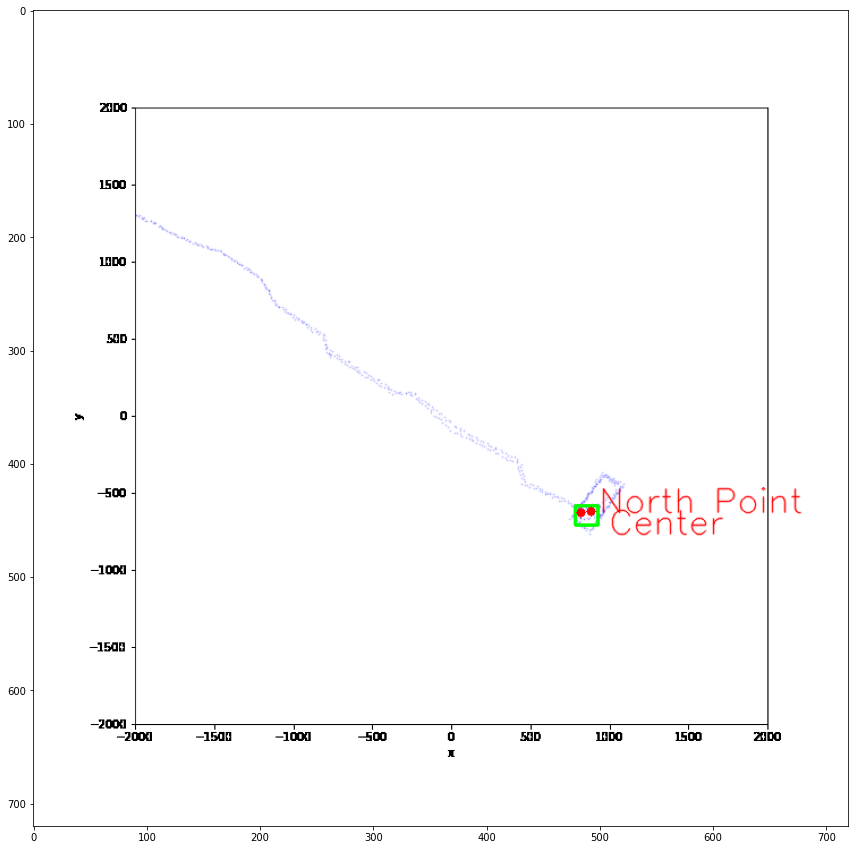

In [9]:
image = (worst_image.detach().cpu().permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes = [worst_pred["boxes"].detach().cpu().numpy().astype(np.int32).tolist()[0]]

keypoints = []
for kps in [worst_pred["keypoints"].detach().cpu().numpy().astype(np.int32).tolist()[0]]:
    keypoints.append([kp[:2] for kp in kps])

visualize(image, bboxes, keypoints)

## Comparison of prediction vs actual

In [25]:
iterator = iter(data_loader_test)
images, targets = next(iterator)
images = list(image.to(device) for image in images)

with torch.no_grad():
    model.to(device)
    model.eval()
    output = model(images)

print("Predictions: \n", output)
print("Targets: \n", targets)

Predictions: 
 [{'boxes': tensor([[337.4544, 351.8940, 354.8402, 365.2571],
        [333.8211, 349.1925, 343.8303, 363.7862],
        [332.7335, 350.2767, 349.6653, 361.2263],
        [343.8614, 352.6274, 354.1930, 368.5607],
        [336.3052, 348.6014, 347.9737, 368.3943],
        [347.1175, 351.1304, 357.6466, 367.2617],
        [331.7586, 346.0822, 357.8935, 370.2496],
        [340.7324, 354.0467, 350.7473, 368.7180],
        [338.6945, 349.5452, 354.4621, 359.8712],
        [330.4889, 347.7114, 339.7270, 360.0041],
        [341.7310, 357.7520, 356.3289, 369.6161],
        [344.7840, 359.5293, 353.7527, 370.8074],
        [330.5659, 352.7581, 340.5229, 367.3120],
        [333.8723, 356.3042, 343.2169, 368.1708],
        [334.2531, 345.8631, 342.7606, 354.9633],
        [337.5383, 356.1861, 347.1248, 369.1153],
        [345.6324, 358.9355, 361.2050, 371.8030],
        [348.3484, 351.9080, 361.1932, 363.1924]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

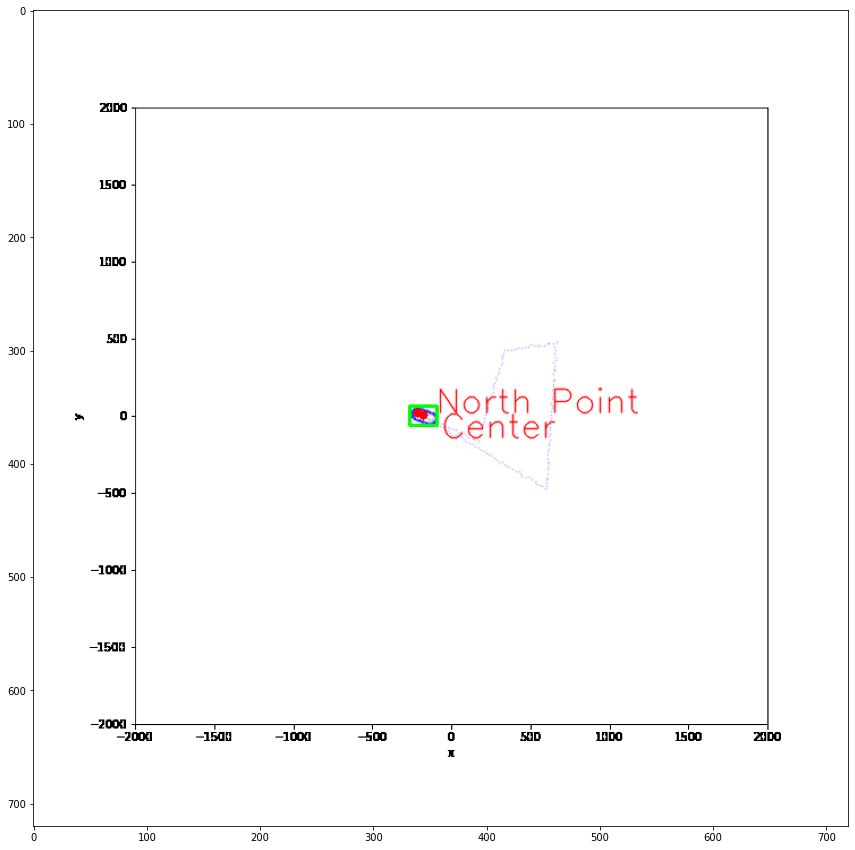

In [32]:
bboxes = targets[0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints = []
for kps in targets[0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints.append([kp[:2] for kp in kps])

# Actual bounding box and keypoints
visualize(image, bboxes, keypoints)

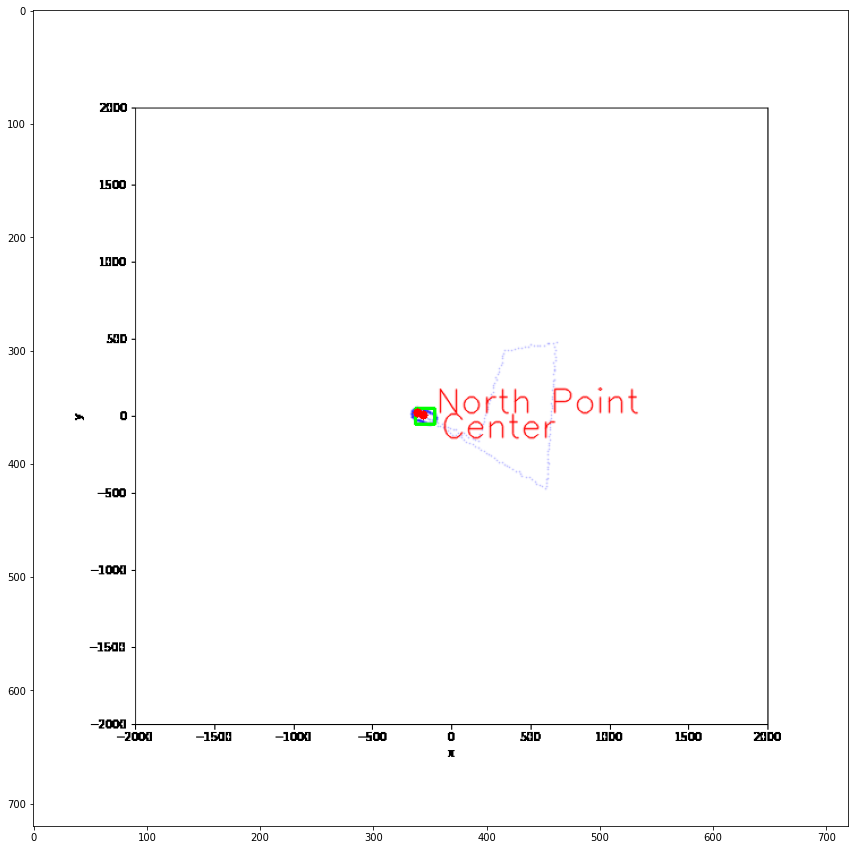

In [33]:
image = (images[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
scores = output[0]['scores'].detach().cpu().numpy()

high_scores_idxs = [np.argmax(scores)]
post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

# Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
# Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
# Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

keypoints = []
for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    keypoints.append([list(map(int, kp[:2])) for kp in kps])

bboxes = []
for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    bboxes.append(list(map(int, bbox.tolist())))
    
# Predicted bounding box and keypoints
visualize(image, bboxes, keypoints)

## Comparison with real GPS data

In [48]:
import pandas as pd
points = pd.read_csv("running_points.csv")
image = dataset_train.image_tensor_from_points(points)[None, :]
# model.load_state_dict(torch.load("keypointsrcnn_weights.pth"))

with torch.no_grad():
    model.to(device)
    model.eval()
    image = image.to(device)
    output = model(image)
print(output)

[{'boxes': tensor([[310.7720, 420.8959, 331.0446, 438.9255],
        [315.9636, 426.1983, 329.8993, 439.3462],
        [310.9707, 420.4404, 323.6910, 434.1736],
        [319.7953, 416.2870, 332.0294, 438.2751],
        [416.6424, 277.1165, 433.4357, 290.5981]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9832, 0.5278, 0.2530, 0.1339, 0.0744], device='cuda:0'), 'keypoints': tensor([[[320.9083, 429.9107,   1.0000],
         [316.5013, 425.6179,   1.0000]],

        [[320.7539, 430.1427,   1.0000],
         [317.2700, 426.6365,   1.0000]],

        [[320.7229, 430.3112,   1.0000],
         [316.4828, 426.0195,   1.0000]],

        [[321.1060, 429.9196,   1.0000],
         [320.2322, 426.4016,   1.0000]],

        [[427.6906, 278.4646,   1.0000],
         [428.5745, 280.2622,   1.0000]]], device='cuda:0'), 'keypoints_scores': tensor([[74.0510, 36.7637],
        [52.7145, 20.1555],
        [51.1179, 19.4601],
        [55.3100,  7.5416],
        

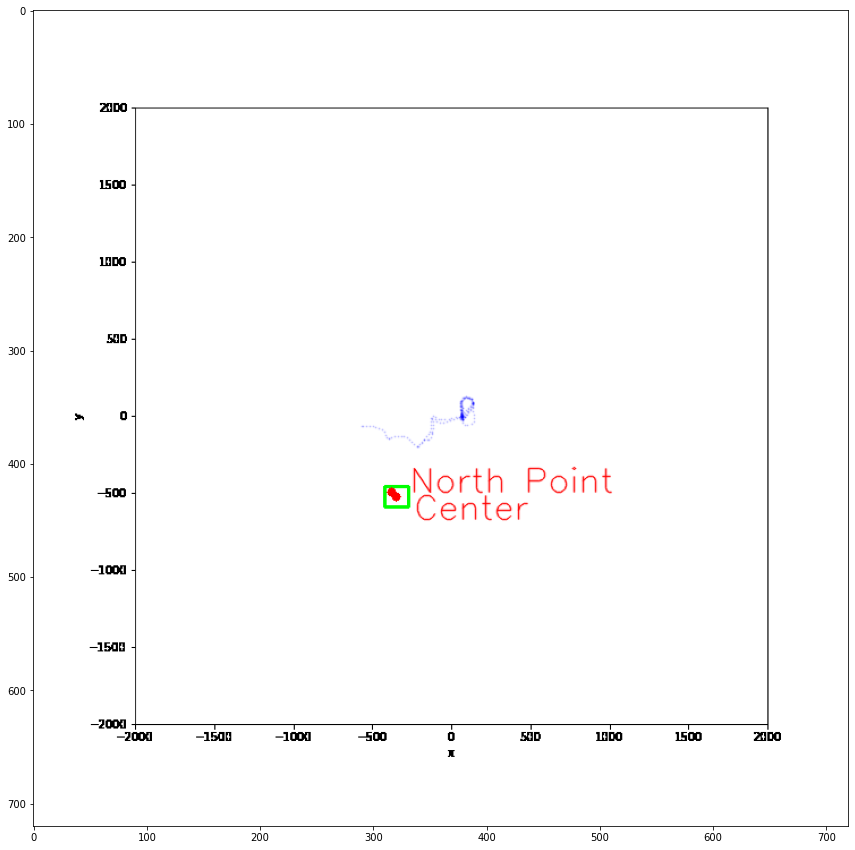

In [49]:
image = (image.permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
scores = output[0]['scores'].detach().cpu().numpy()

high_scores_idxs = [np.argmax(scores)]
post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

# Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
# Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
# Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

keypoints = []
for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    keypoints.append([list(map(int, kp[:2])) for kp in kps])

bboxes = []
for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    bboxes.append(list(map(int, bbox.tolist())))
    
# Prediction from out of training example
visualize(image, bboxes, keypoints)